In [4]:
import os
import ast

def find_imports(repo_path):
    imports = set()

    for root, _, files in os.walk(repo_path):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r') as f:
                        tree = ast.parse(f.read())
                        for node in ast.walk(tree):
                            if isinstance(node, ast.Import):
                                for alias in node.names:
                                    imports.add(f"import {alias.name}")
                            elif isinstance(node, ast.ImportFrom):
                                module = node.module if node.module else ''
                                names = ', '.join(alias.name for alias in node.names)
                                imports.add(f"from {module} import {names}")
                except Exception as e:
                    print(f"Error parsing {file_path}: {e}")

    return sorted(imports)

# Usage
repo_path = r"C:\repo\nranthony\hamiltonian-nn"
all_imports = find_imports(repo_path)
for imp in all_imports:
    print(imp)

from data import get_dataset
from hnn import HNN
from hnn import HNN, PixelHNN
from nn_models import MLP
from nn_models import MLPAutoencoder, MLP
from urllib.request import urlretrieve
from utils import L2_loss
from utils import L2_loss, rk4
from utils import L2_loss, to_pickle, from_pickle
from utils import choose_nonlinearity
from utils import read_lipson, str2array
from utils import rk4
from utils import to_pickle, from_pickle
import argparse
import autograd
import autograd.numpy
import gym
import imageio
import numpy
import os
import pickle
import scipy
import scipy.integrate
import scipy.misc
import shutil
import sys
import torch
import zipfile


Expected Hamiltonian: -29.43
Computed Hamiltonian: -29.43


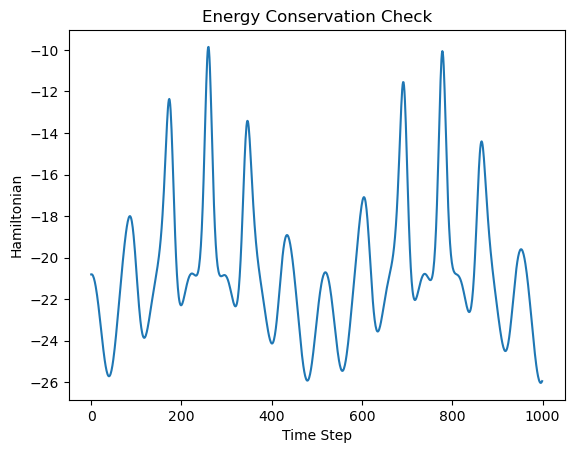

In [2]:
import autograd.numpy as np  # Use autograd.numpy instead of numpy

def hamiltonian_fn(coords, m1, m2, l1, l2, g):
    q, p = np.split(coords, 2)
    theta1, theta2 = q
    p_theta1, p_theta2 = p
    
    # Calculate components of the Hamiltonian
    denominator = 2 * m2 * l1**2 * l2**2 * (m1 + m2 * np.sin(theta1 - theta2)**2)
    
    kinetic_energy = (
        m2 * l1**2 * p_theta1**2 +
        (m1 + m2) * l1**2 * l2**2 * p_theta2**2 -
        2 * m2 * l1 * l2 * p_theta1 * p_theta2 * np.cos(theta1 - theta2)
    ) / denominator
    
    potential_energy = (
        -(m1 + m2) * g * l1 * np.cos(theta1) -
        m2 * g * l2 * np.cos(theta2)
    )
    
    H = kinetic_energy + potential_energy
    return H

# Example usage and cross-checks
coords = np.array([0.0, 0.0, 0.0, 0.0]) # Both angles and momenta are zero
m1, m2, l1, l2, g = 1.0, 1.0, 1.0, 1.0, 9.81

# Manually calculated Hamiltonian for the special case
expected_H = -(m1 + m2) * g * l1 - m2 * g * l2

# Compute using the function
computed_H = hamiltonian_fn(coords, m1, m2, l1, l2, g)

print("Expected Hamiltonian:", expected_H)
print("Computed Hamiltonian:", computed_H)

# Define a simple simulation function
def simulate_double_pendulum(coords, m1, m2, l1, l2, g, dt, steps):
    energy = []
    for _ in range(steps):
        H = hamiltonian_fn(coords, m1, m2, l1, l2, g)
        energy.append(H)
        # Simple update (this is not a proper integrator, just for illustration)
        coords[:2] += coords[2:] * dt # Update angles
        coords[2:] -= (np.array([m1 + m2, m2]) * g * np.sin(coords[:2])) * dt # Update momenta
    return energy

# Initial conditions
coords = np.array([np.pi/4, np.pi/4, 0.0, 0.0])
m1, m2, l1, l2, g = 1.0, 1.0, 1.0, 1.0, 9.81
dt = 0.01
steps = 1000

energy = simulate_double_pendulum(coords, m1, m2, l1, l2, g, dt, steps)

plt.plot(energy)
plt.xlabel('Time Step')
plt.ylabel('Hamiltonian')
plt.title('Energy Conservation Check')
plt.show()


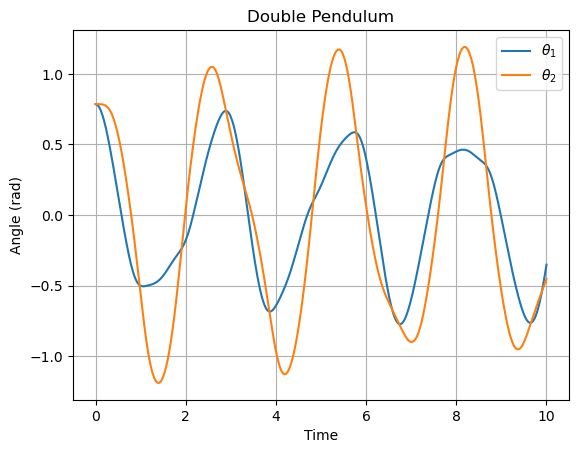

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters of the double pendulum
m1, m2 = 1.0, 1.0
l1, l2 = 1.0, 1.0
g = 9.81

# Define the system of ODEs for the double pendulum
def double_pendulum(t, y):
    theta1, theta2, p_theta1, p_theta2 = y
    delta = theta2 - theta1
    
    denominator1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta)**2
    denominator2 = (l2 / l1) * denominator1
    
    dtheta1_dt = (p_theta1 * l2 - p_theta2 * l1 * np.cos(delta)) / (l1**2 * l2 * denominator1)
    dtheta2_dt = (p_theta2 * (m1 + m2) * l1 - p_theta1 * m2 * l2 * np.cos(delta)) / (m2 * l2**2 * l1 * denominator2)
    
    dp_theta1_dt = -(m1 + m2) * g * l1 * np.sin(theta1) - dtheta1_dt * dtheta2_dt * m2 * l1 * l2 * np.sin(delta)
    dp_theta2_dt = -m2 * g * l2 * np.sin(theta2) + dtheta1_dt * dtheta2_dt * m2 * l1 * l2 * np.sin(delta)
    
    return [dtheta1_dt, dtheta2_dt, dp_theta1_dt, dp_theta2_dt]

# Initial conditions: [theta1, theta2, p_theta1, p_theta2]
y0 = [np.pi / 4, np.pi / 4, 0.0, 0.0]

# Time span for the integration
t_span = (0, 10)

# Time points where solution is desired
t_eval = np.linspace(0, 10, 1000)

# Solve the ODE
solution = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval)

# Extract the solution
t = solution.t
theta1 = solution.y[0]
theta2 = solution.y[1]

# Plot the solution
plt.plot(t, theta1, label=r'$\theta_1$')
plt.plot(t, theta2, label=r'$\theta_2$')
plt.xlabel('Time')
plt.ylabel('Angle (rad)')
plt.title('Double Pendulum')
plt.legend()
plt.grid(True)
plt.show()
